<a href="https://colab.research.google.com/github/sharlobo/nlp-assignment1/blob/main/NLP_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 1: Frequency Analysis and Visualization**
## *Sentimental Laughter - Analyzing Poetic Moods*
Sharon Lobo

### **Dataset: Gutenberg Poem Dataset:** https://huggingface.co/datasets/google-research-datasets/poem_sentiment

This assignment is meant to explore sentiment analysis on a poem dataset.
It will involve the following:
- cleaning and preparing data for analysis
- splitting poems by sentiment categories
- analyzing common words (frequencies) and two-word phrases
- visualizing patterns with word clouds
- comparing results + analysis

## **TASK 1: DATA ANALYSIS**

### **1.1 Understanding the Data**
Brief analysis of the dataset structure.

In [181]:
# huggingface library

!pip install datasets

In [182]:
# importing, loading the sentiment dataset

from datasets import load_dataset

# gutenberg poem sentiment dataset
dataset = load_dataset("google-research-datasets/poem_sentiment")

# dataset info/structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})


For the dataset above, we can see the columns structure is as follows:
- includes id: index of an example
- verse_text: the raw text of the poem verse
- label: sentiment label, wether positive or negative. In this dataset:

    0 = negative / 1 = positive / 2 = no impact and 3 = mixed (both negative and positive)

The dataset has a train split of 892, validation of 105, and a test split of 104

In [183]:
# checking out the train split
train_data = dataset["train"]
print(train_data[0]) # example 1

{'id': 0, 'verse_text': 'with pale blue berries. in these peaceful shades--', 'label': 1}


From this first example, the text has been classified as positive! which checks out with the language used.

In [184]:
# pandas dataframe

import pandas as pd

df = pd.DataFrame(train_data)

# sanity check
df.head()

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3


In [185]:
# more structure analysis
df.info()

# sentiment analysis label check count
df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          892 non-null    int64 
 1   verse_text  892 non-null    object
 2   label       892 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 21.0+ KB


,count
label,
2,555
0,155
1,133
3,49


Interestingly enough, it seems like the dataset has an overwhelming majority of the text classified as 2 - no impact. The split between negative and positive however does seem to be a bit more even.

### **1.2 Preprocessing**

In [186]:
# import libraries
import pandas as pd
import string

# loading train split
dataset = load_dataset("google-research-datasets/poem_sentiment", split="train")

# pandas dataframe
df = pd.DataFrame(dataset)

# sanity check
len(df)

892

In [187]:
# mapping the numeric values of the labels into text
label_mapping = {0: 'negative', 1: 'positive', 2: 'no impact', 3: 'mixed'}
df['label'] = df['label'].map(label_mapping)

# filtering to only three classes
df = df[df['label'].isin(['negative','positive','mixed'])].reset_index(drop=True)

# sanity check
df['label'].value_counts()



,count
label,
negative,155
positive,133
mixed,49


In [188]:
# removing hardcoded list of redundant words
redundant_words = ["thee", "thy", "the", "and", "to", "of", "with", "as", "by", "a", "for", "at", "by", "in", "that", "it", "is", "on", "but", "she", "he", "her","him", "thou", "i", "so", "their", "your", "from", "its", "are", "were", "his", "your", "that", "when", "which", "was", "while", "through", "me", "while", "all", "what", "will", "like", "our", "this", "than", "whose"]
# cleaning function to clean/lowercasing dataset text

def cleaning_function(text):
    text = text.lower()  # lowercaseing - for word consistency
    text = text.translate(str.maketrans('', '', string.punctuation)) # removing punctuation - making sure we focus ONLY on text
    text = text.split() # text as individual words
    filtered_text = [word for word in text if word not in redundant_words] # removal of words in redudant words list
    return ' '.join(filtered_text) # filtered words into string

# testing it out with dataset example
text = "sounded o'er earth and sea its blast of war,"
print(cleaning_function(text))

sounded oer earth sea blast war


It works! the cleaning function successfully removed redundant words like "and" and "of" while also getting rid of the extra punctuation! all of the cleaning is necessary in order to ensure that the text is consistent.

The purpose of all this cleaning is to make sure that meaningful, filtered words only are analyzed.

To make analysis is easier, I will create dataframes for the 3 corresponding sentiments in order to apply the preprocessing steps to each sentiment category.



In [189]:
# sentiment categorization
df_positive = df[df['label'] == 'positive'].reset_index(drop=True)
df_negative = df[df['label'] == 'negative'].reset_index(drop=True)
df_mixed = df[df['label'] == 'mixed'].reset_index(drop=True)

# applying the cleaning function above to each dataframe, in addition i will create a cleaned text column for the filtered text.
df_positive['cleaned_text'] = df_positive['verse_text'].apply(cleaning_function)
df_negative['cleaned_text'] = df_negative['verse_text'].apply(cleaning_function)
df_mixed['cleaned_text'] = df_mixed['verse_text'].apply(cleaning_function)

# sanity check with one df
df_positive.head()

,id,verse_text,label,cleaned_text
0,0,with pale blue berries. in these peaceful shad...,positive,pale blue berries these peaceful shades
1,16,that has a charmingly bourbon air.,positive,has charmingly bourbon air
2,20,"brightly expressive as the twins of leda,",positive,brightly expressive twins leda
3,23,in monumental pomp! no grecian drop,positive,monumental pomp no grecian drop
4,62,and lips where heavenly smiles would hang and ...,positive,lips where heavenly smiles would hang blend


By preprocessing and breaking it down to each sentiment category, analysis will prove to be easier if wanting to check through individual sentiments. This will also make comparing patterns and differences much easier.

## **TASK 2: TEXT ANALYSIS**

### **2.1 Frequency Analysis**
Analyzing how often words appear in each sentiment, and which are the most frequent.

Following the same structure as Lab 1, applying it to each one of my cleaned text sentiment categories.


In [190]:
# combining the categories into single string

# positive text into single string
positive_text = ' '.join(df_positive['cleaned_text'])
positive_words = positive_text.split()

# negative text
negative_text = ' '.join(df_negative['cleaned_text'])
negative_words = negative_text.split()

# mixed text
mixed_text = ' '.join(df_mixed['cleaned_text'])
mixed_words = mixed_text.split()

In [191]:
# function for word frequency

def word_freq(text):
    words = text.split()
    freq = {}
    for word in words:
        if word in freq:
            freq[word] += 1
        else:
            freq[word] = 1
    return freq

# calculating the frequency for each sentiment
positive_freq = word_freq(positive_text)
negative_freq = word_freq(negative_text)
mixed_freq = word_freq(mixed_text)

# display example - positive sentiment
print("positive sentiment frequency:")
for word, freq in sorted(positive_freq.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{word}: {freq}")

positive sentiment frequency:
sweet: 7
heart: 7
love: 4
my: 4
thought: 3
calm: 3
days: 3
hope: 3
king: 3
those: 3
full: 3
shining: 3
us: 3
soft: 3
delight: 3
bright: 3
happy: 3
swifter: 3
far: 3
soul: 3


In [192]:
# negative sentiment frequencies
print("negative sentiment frequency:")
for word, freq in sorted(negative_freq.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{word}: {freq}")



negative sentiment frequency:
eyes: 5
world: 4
pain: 4
oer: 3
sea: 3
cold: 3
loss: 3
rude: 3
set: 3
heart: 3
madness: 3
dead: 3
comes: 3
my: 3
till: 3
not: 3
would: 3
waters: 3
strange: 3
they: 3


A bit interesting how "eyes" is classified as the most frequent negative word? followed by "world" which seem to be a bit more neutral in my opinion.

In [193]:
# mixed sentiment
print("mixed sentiment frequency:")
for word, freq in sorted(mixed_freq.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{word}: {freq}")

mixed sentiment frequency:
death: 4
love: 4
you: 4
how: 4
would: 3
generals: 2
not: 2
or: 2
days: 2
hope: 2
sigurd: 2
we: 2
right: 2
bright: 2
had: 2
heaven: 2
my: 2
heart: 2
lips: 2
nor: 2


It surprises me that "death"  is not classified as a more negative sentiment as well as "love".

### *Frequency Analysis on Two-Word Phrases*

In [194]:
# function for two word phrases - bigrams

def bigram_freq(text): # pairs of consecutive words
    words = text.split() # split  cleaned text
    bigrams = [] # list for bigrams
    for i in range(len(words) - 1):
        bigrams.append((words[i], words[i+1])) # consecutive words

    freq = {} # frequency
    for bigram in bigrams:
        if bigram in freq:
            freq[bigram] += 1
        else:
            freq[bigram] = 1

    return freq

# function for each sentiment category
positive_bigram_freq = bigram_freq(positive_text)
negative_bigram_freq = bigram_freq(negative_text)
mixed_bigram_freq = bigram_freq(mixed_text)

# top 10 bigrams for each sentiment
print("positive sentiment bigrams:\n")
for bigram, freq in sorted(positive_bigram_freq.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{bigram[0]} {bigram[1]}: {freq}")

print("negative sentiment bigrams:\n")
for bigram, freq in sorted(negative_bigram_freq.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{bigram[0]} {bigram[1]}: {freq}")

print("mixed sentiment bigrams:\n")
for bigram, freq in sorted(mixed_bigram_freq.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{bigram[0]} {bigram[1]}: {freq}")

positive sentiment bigrams:

swifter far: 2
play uppe: 2
pale blue: 1
blue berries: 1
berries these: 1
these peaceful: 1
peaceful shades: 1
shades has: 1
has charmingly: 1
charmingly bourbon: 1
negative sentiment bigrams:

why lonesome: 1
lonesome day: 1
day then: 1
then worthless: 1
worthless gaud: 1
gaud or: 1
or two: 1
two sounded: 1
sounded oer: 1
oer earth: 1
mixed sentiment bigrams:

how you: 2
peruse conquered: 1
conquered fame: 1
fame heroes: 1
heroes victories: 1
victories mighty: 1
mighty generals: 1
generals do: 1
do not: 1
not envy: 1


I think that for positive sentiment this really helps, and to an extent for negative but I notice that the frequency count is a bit low for each, so I'm unsure how well it really applies to an analysis.

However, bigrams can really help gather better context than single words could. I think in poetry it can especially show a poets emotion more clearly in certain instances.

### **2.2 Visualization**

Creating word clouds!


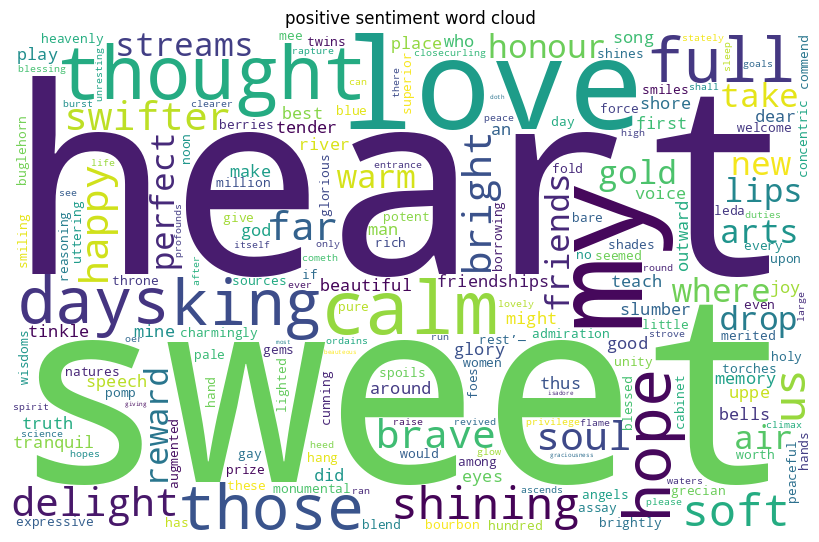

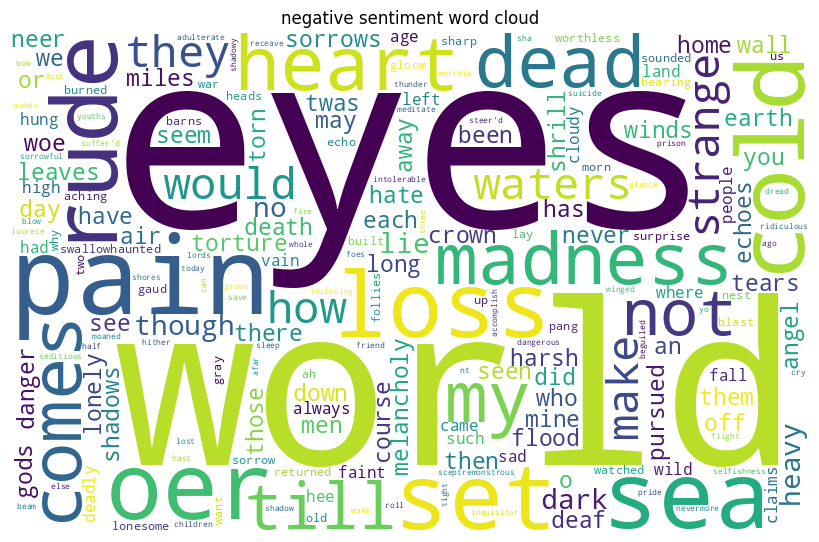

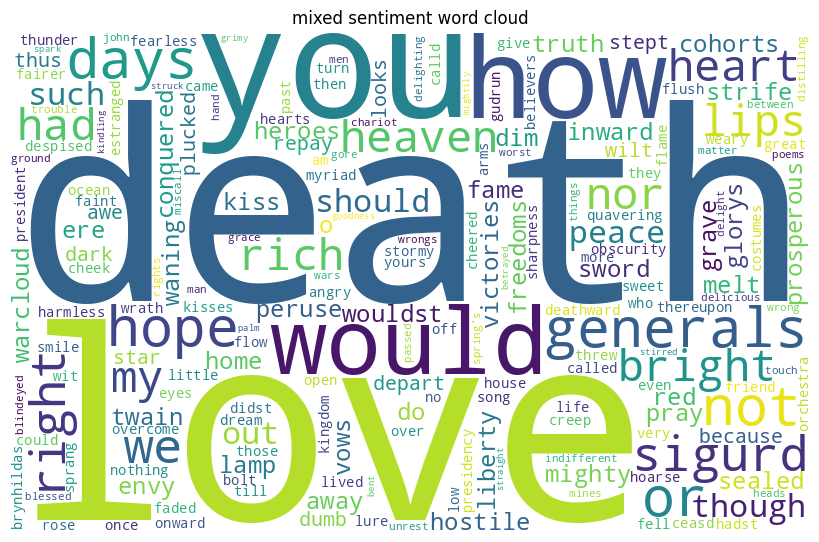

In [195]:
# word cloud!

!pip install wordcloud

# imports
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# function for all sentiments
def word_cloud(freq_dict, title):
  wc = WordCloud(width=800, height=500, background_color='white')\
    .generate_from_frequencies(freq_dict)
  plt.figure(figsize=(8,8), facecolor=None)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.title(title)
  plt.show()

# wc for each sentiment
word_cloud(positive_freq, 'positive sentiment word cloud')
word_cloud(negative_freq, 'negative sentiment word cloud')
word_cloud(mixed_freq, 'mixed sentiment word cloud')

## **TASK 3: DISCUSSION AND INSIGHTS**

###**3.1 Word Cloud Comparison**

**Positive Sentiment Word Cloud:**
- words that stand out: *heart, sweet, love, hope, happy, calm*
- these words definitely all have positive connotations and are very sentimental, human emotion centered words!
- poems about very positive, happy, emotional experiences

**Negative Sentiment Word Cloud:**
- stand out words: *eyes?, world?, loss, pain, cold, sea, rude*
- words that are typical of some sort of suffering
- fear, very negative use words for sure
- these poems have some grief element, darker words

**Mixed Sentiment Word Cloud:**
- stand out words: *love, death, hope, heaven, days, bright*
- both positive and negative words are included
- suggesting that words can also conflict in different emotions
- e.g love can also be a negative feeling if paired with say heartbreak, death can sometimes be described as liberating etc etc.
- poems especially deal with complex themes and human emotion that can be hard for a machine to truly interpret.

Overall, the clouds are very distinct in terms of positive/negative so this was a successful visualization as we can see clear differences.

Other words have also shown to appear multiple times such as those in mixed indicating that they can take on different meaning depending on the context/intention of the poet.

###**3.2 Insights**

I think most of all, I had not considered that poetry can be very abstract in the way it uses words so while I was confused why some words were considered negative or more positive I realized that there is a lot more nuance in word use in cases like this.

I also had to go back and edit my redundant word list many times, as I saw them taking over the word cloud. So, this was more time consuming than I believed it would be, I never noticed before how many words can be repeated so many times, or different variations of them. Once I removed enough of them I started really seeing the big meaningful words identified.

Although this is just the first assignment, I am excited to try different visualization techniques, apply lemmatization which would also help group variation of words better.

To make this process better, I could have just combined my redundant words list with a set stopword list but truly I wanted to just test it out manually to see how much they impact analysis. In the future, I will try to just load up a list.